# Part I - Loan Data Exploration
## by Carmen Wong

## Introduction
This project dives deep into the loan dataset from Prosper. It contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.

## Required Packages

In [404]:
# import all packages and set plots to be embedded inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams

%matplotlib inline

In [405]:
DATA_PATH = 'data'
DATA_FILE = 'prosperLoanData.csv'
DATASET = os.path.join(DATA_PATH, DATA_FILE)
CLEANED_DATA = os.path.join(DATA_PATH, 'cleaned_data')
BASE_COLOR = sns.color_palette()[0]
FIG_SIZE = (15,5)
FIG_SIZE_TWO_ROWS = (15,10)

sns.set_theme(style='darkgrid')
rcParams['figure.figsize'] = (10,5)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 13
rcParams['axes.titlepad'] = 10

## Preliminary Wrangling

### Data Quality Issues
* Duplicate Rows
    * 871 rows with same ListingKey and ListingNumber
    
* Employment Status
    * `['Self-employed', 'Employed', 'Not available', 'Full-time', 'Other', nan, 'Not employed', 'Part-time', 'Retired']`
    * 'Full-time' is 'Employed'
    * nan is same as 'Not available'
    * 'Part-time' is 'Employed' ??? 
    * 'Not employed' is same 'Unemployed'
    
* CreditScoreRangeLower and CreditScoreRangeUpper
    * 591 rows with NaN
    * Zero value

* ProsperScore
    * This is Prosper risk score. Need better name.
    
* IncomeRange
    * 806 rows with 'Not employed', should be same as $0
    * 621 rows with '$0'
* AmountDelinquent
    * 7489 rows are nulls
    * 89009 rows with 0
* BorrowerState
    * 5471 rows are nulls
* BorrowerAPR
    * 24 rows are nulls
* AmountDelinquent
    * 3755 rows are nulls


### Data Tidiness Issues
* CreditScoreRangeLower & CreditScoreRangeUpper can be melt into two colums (e.g. range, score)
* It is better to take the average of the credit score they both have a strong linear relationship

In [406]:
def get_loan_dataset():
    df = pd.read_csv(DATASET, parse_dates=[2, 6])
    return df

### Check and Drop Duplicates

In [407]:
def drop_duplicates():
    '''
    Drop duplicates with same ListingNumber
    '''
    df = get_loan_dataset()
    
    n_rows = df.shape[0]
    dups = df[df.ListingNumber.duplicated()==True].sort_values(by=['ListingNumber'])
    
    if dups.shape[0] > 0:
        df = df.drop(dups.index)
    
    assert df[df.ListingNumber.duplicated()==True].sort_values(by=['ListingNumber']).shape[0] == 0
    assert n_rows - dups.shape[0] == df.shape[0]
    
    df.to_csv(CLEANED_DATA, index=False)
    return df

df = drop_duplicates()

### Select potential interested columns

In [408]:
def select_potential_columns():
    '''
    Select interested exploring columns
    '''
    df = pd.read_csv(CLEANED_DATA)
    int_cols = ['ListingNumber', 'Term', 'LoanStatus', 'ListingCreationDate',
                'BorrowerAPR', 'BorrowerRate', 
                'BorrowerState', 'EmploymentStatus',
                'CreditScoreRangeLower', 'CreditScoreRangeUpper',
                'IncomeRange', 'LoanOriginalAmount',
                'CurrentDelinquencies', 'AmountDelinquent']
    df_trimmed = df[int_cols]
    
    df_trimmed.to_csv(CLEANED_DATA, index=False)
    return df_trimmed

df = select_potential_columns()

### Cleaning Data Quality Issues

In [409]:
def clean_employment_status():
    ''' Clean 'employment status' quality data issues '''
        
    df = pd.read_csv(CLEANED_DATA)
    
    # Replace Full-time and Part-time to Employed, no-available to N/A, and 'Not employed' to unemployed
    df['EmploymentStatus'].replace(["Full-time", "Part-time", 'Not available', 'Not employed'], 
                                   ['Employed', 'Employed', 'Not-available', 'Unemployed'], inplace=True)
    
    # Fill NaN with 'N/A'
    df.EmploymentStatus.fillna('Not-available', inplace=True)
    
    df.to_csv(CLEANED_DATA, index=False)
    return df

df = clean_employment_status()

In [410]:
def clean_credit_score():
    ''' 
    Clean credit score data quality issues.
    '''   
    df = pd.read_csv(CLEANED_DATA)
    
    # Replace NaN score with the mean for CreditScoreRangeLower
    mean = df.CreditScoreRangeLower.mean()
    df.CreditScoreRangeLower.fillna(mean, inplace=True)
    
    # Replace NaN score with the mean for CreditScoreRangeUpper
    mean = df.CreditScoreRangeUpper.mean()
    df.CreditScoreRangeUpper.fillna(mean, inplace=True)
    
    # Drop rows with zero value
    zeros = df[df.CreditScoreRangeLower==0]
    df.drop(zeros.index, inplace=True)
    assert df[df.CreditScoreRangeLower==0].shape[0] == 0
    
    # Create a column for average credit score
    df['AvgCreditScore'] = (df.CreditScoreRangeLower + df.CreditScoreRangeUpper)/2
    
    # Drop the two CreditScoreRange columns
    df.drop(labels=['CreditScoreRangeLower', 'CreditScoreRangeUpper'], axis=1, inplace=True)
    
    df.to_csv(CLEANED_DATA, index=False)
    return df

df = clean_credit_score()

In [411]:
def clean_prosper_score():
    '''
    Rename column label to reflex it's meaning
    '''
    df = pd.read_csv(CLEANED_DATA)
    
    df.rename(columns={'ProsperScore':'ProsperRiskScore'}, inplace=True)
    
    df.to_csv(CLEANED_DATA, index=False)
    return df

In [412]:
def clean_income_range():
    '''
    Clean IncomeRange data quality issues
    '''
    df = pd.read_csv(CLEANED_DATA)
    df.IncomeRange.replace(['Not employed'], ['$0'], inplace=True)
    
    assert df.query('IncomeRange=="Not employed"').shape[0] == 0
    
    df.to_csv(CLEANED_DATA, index=False)
    return df

df = clean_income_range()    

In [413]:
def clean_borrower_apr():
    '''
    Clean BorrowerAPR data quality issue
    '''
    df = pd.read_csv(CLEANED_DATA)
    nulls = df[df.BorrowerAPR.isnull()==True]
    df.drop(nulls.index, inplace=True)
    
    assert df.BorrowerAPR.isnull().sum() == 0
    
    df.to_csv(CLEANED_DATA, index=False)
    return df

df = clean_borrower_apr()

In [414]:
def clean_borrower_state():
    '''
    Clean borrower state data quality issue
    '''
    df = pd.read_csv(CLEANED_DATA)
    nulls = df[df.BorrowerState.isnull()==True]
    df.drop(nulls.index, inplace=True)
    
    assert df.BorrowerState.isnull().sum() == 0
    
    df.to_csv(CLEANED_DATA, index=False)
    return df

df = clean_borrower_state()

In [415]:
def clean_delinquencies():
    '''
    Clean CurrentDelinquencies & AmountDelinquent data quality issue
    '''
    # AmountDelinquent
    df = pd.read_csv(CLEANED_DATA)
    nulls = df[df.AmountDelinquent.isnull()==True]
    df.drop(nulls.index, inplace=True)
    
    assert df.AmountDelinquent.isnull().sum() == 0
    
    df.to_csv(CLEANED_DATA, index=False)
    return df

df = clean_amount_delinquent()

In [416]:
def add_credit_range_column():
    '''
    Add a column for credit score range.
    '''
    df = pd.read_csv(CLEANED_DATA)
    
    df['CreditRange'] = '0-499'
    df.loc[(df.AvgCreditScore >= 500), 'CreditRange'] = '500-549'
    df.loc[(df.AvgCreditScore >= 550), 'CreditRange'] = '550-599'
    df.loc[(df.AvgCreditScore >= 600), 'CreditRange'] = '600-645'
    df.loc[(df.AvgCreditScore >= 650), 'CreditRange'] = '650-699'
    df.loc[(df.AvgCreditScore >= 700), 'CreditRange'] = '700-749'
    df.loc[(df.AvgCreditScore >= 750), 'CreditRange'] = '750-799'
    df.loc[(df.AvgCreditScore >= 800), 'CreditRange'] = '800-845'
    df.loc[(df.AvgCreditScore >= 850), 'CreditRange'] = '850-999'  
    
    df.to_csv(CLEANED_DATA, index=False)
    return df

df = add_credit_range_column()

In [417]:
df.head(2)

,ListingNumber,Term,LoanStatus,ListingCreationDate,BorrowerAPR,BorrowerRate,BorrowerState,EmploymentStatus,IncomeRange,LoanOriginalAmount,CurrentDelinquencies,AmountDelinquent,AvgCreditScore,CreditRange
0,193129,36,Completed,2007-08-26 19:09:29.263,0.16516,0.158,CO,Self-employed,"$25,000-49,999",9425,2.0,472.0,649.5,600-645
1,1209647,36,Current,2014-02-27 08:28:07.900,0.12016,0.092,CO,Employed,"$50,000-74,999",10000,0.0,0.0,689.5,650-699


In [418]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103707 entries, 0 to 103706
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ListingNumber         103707 non-null  int64  
 1   Term                  103707 non-null  int64  
 2   LoanStatus            103707 non-null  object 
 3   ListingCreationDate   103707 non-null  object 
 4   BorrowerAPR           103707 non-null  float64
 5   BorrowerRate          103707 non-null  float64
 6   BorrowerState         103707 non-null  object 
 7   EmploymentStatus      103707 non-null  object 
 8   IncomeRange           103707 non-null  object 
 9   LoanOriginalAmount    103707 non-null  int64  
 10  CurrentDelinquencies  103707 non-null  float64
 11  AmountDelinquent      103707 non-null  float64
 12  AvgCreditScore        103707 non-null  float64
 13  CreditRange           103707 non-null  object 
dtypes: float64(5), int64(3), object(6)
memory usage: 11.

## Univariate Exploration
In this section, I explore the distributions of individual variables in prepare for the next step to explore the relationship between variables.

### Explore Catagorical Variables

> ### Explore Terms
> * *77.12% of loans are with 36 months term*
> * *21.45% of loans are with 60 months terms*

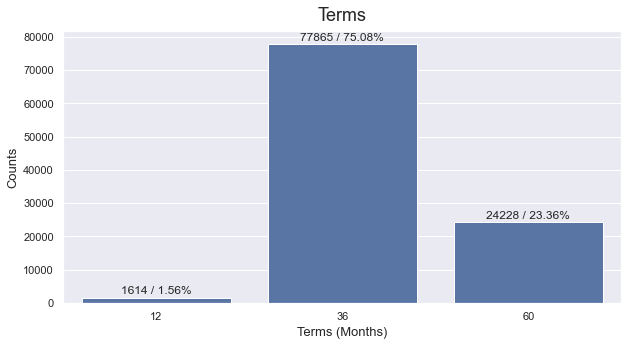

In [419]:
def explore_terms():
    '''
    Explore variable terms.
    '''
    df = pd.read_csv(CLEANED_DATA)
    order = sorted(df.Term.unique().tolist())
    ax = sns.countplot(data=df, x='Term', color=BASE_COLOR, order=order)
    ax.set(title='Terms',
           xlabel='Terms (Months)',
           ylabel='Counts')
    
    for i, v in enumerate(order):
        count = df.query(f'Term=={v}').ListingNumber.count()
        pct = count / df.shape[0] * 100
        plt.text(i, count+1000, f'{count} / {round(pct, 2)}%', ha='center')
        
explore_terms()

> ### Explore Loan Status
> * *10.59% of loans were charged off*
> * *4.39% of loans were defaulted*
> * *About 2% of loans were past due*
> * *Which mean bank has about 18 to 20% risk when lending out money*

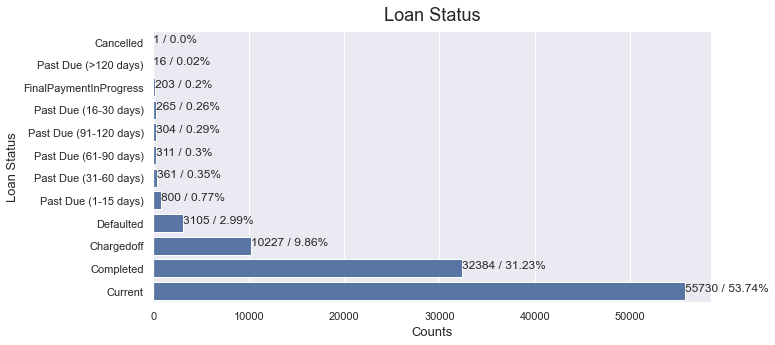

In [420]:
def explore_loan_status():
    '''
    Explore variable loan status
    '''
    df = pd.read_csv(CLEANED_DATA)
    ls = df.groupby(['LoanStatus']).ListingNumber.count().sort_values()
    ls = ls.reset_index()
    ax = sns.barplot(data=ls, x='ListingNumber', y='LoanStatus', color=BASE_COLOR)
    ax.set(title='Loan Status',
           xlabel='Counts',
           ylabel='Loan Status')
    
    for i, v in enumerate(ls['ListingNumber']):
        counts = v
        pct = counts / df.shape[0] * 100
        plt.text(v+1, i, f'{v} / {round(pct, 2)}%')

explore_loan_status()

> ### Explore Employment Status

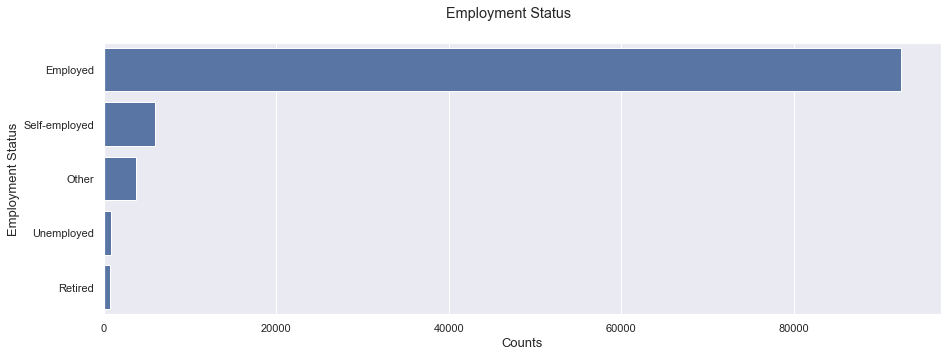

In [421]:
def explore_employment_status():
    '''
    Explore variable employment status.
    '''
    df = pd.read_csv(CLEANED_DATA)
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    fig.suptitle('Employment Status')
    
    order = ['Employed', 'Self-employed', 'Other', 'Unemployed', 'Retired']
    sns.countplot(data=df, y='EmploymentStatus', ax=ax1, color=BASE_COLOR, order=order)

    ax1.set(xlabel='Counts',
            ylabel='Employment Status')
    
#     props = {'rotation': 90}
#     plt.setp(ax1.get_xticklabels(), **props)
    
explore_employment_status()

### Explore Quantitative Variables

> ### Explore Annual APR

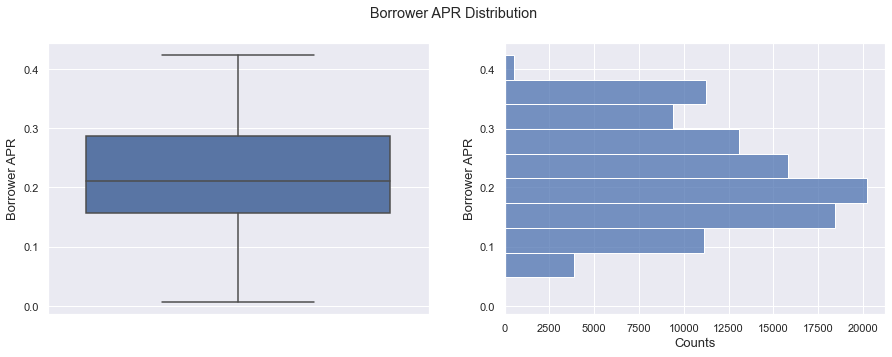

In [422]:
def explore_apr(df):
    '''
    Explore annual APR varible.
    '''
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=FIG_SIZE)
    fig.suptitle('Borrower APR Distribution')
    sns.boxplot(data=df, y='BorrowerAPR', ax=ax1)
        
    ax1.set(xlabel='',
            ylabel='Borrower APR')
    
    sns.histplot(data=df, y='BorrowerAPR', ax=ax2, bins=10, alpha=0.75)

    ax2.set(xlabel='Counts',
            ylabel='Borrower APR')
    
explore_apr(df)

> ### Explore Rate

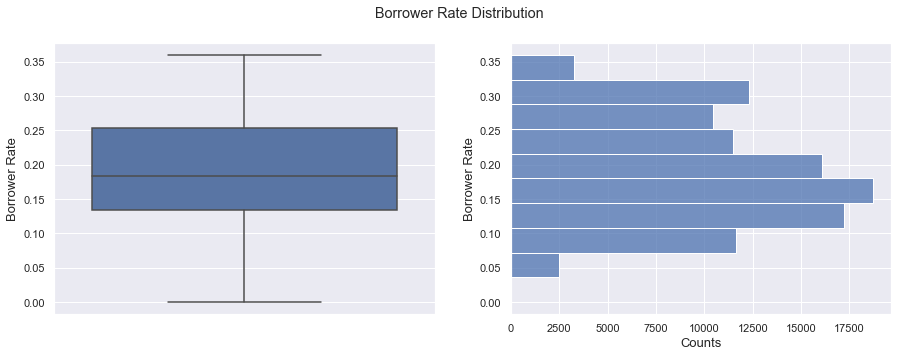

In [423]:
def explore_rate(df):
    '''
    Explore variable annual rate.
    '''
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=FIG_SIZE)
    fig.suptitle('Borrower Rate Distribution')
    sns.boxplot(data=df, y='BorrowerRate', ax=ax1)
    
    ax1.set(xlabel='',
            ylabel='Borrower Rate')
    
    sns.histplot(data=df, y='BorrowerRate', ax=ax2, bins=10, alpha=0.75)

    ax2.set(xlabel='Counts',
            ylabel='Borrower Rate')
    
explore_rate(df)

> ### Explore Income Range
> * Most people's income is between 25K to 75K

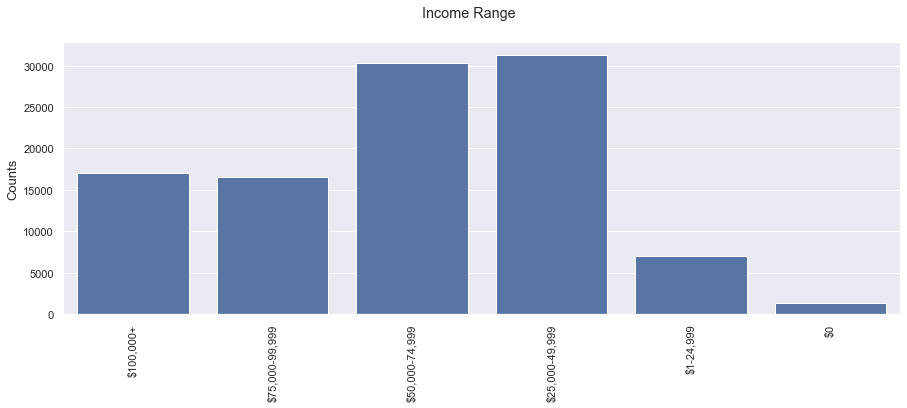

In [424]:
def explore_income_range():
    '''
    Explore income range variable.
    '''
    df = pd.read_csv(CLEANED_DATA)
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    fig.suptitle('Income Range')
    order = ['$100,000+', '$75,000-99,999', '$50,000-74,999', '$25,000-49,999', '$1-24,999', '$0']
    sns.countplot(data=df, x='IncomeRange', ax=ax1, color=BASE_COLOR, order=order)

    ax1.set(xlabel='',
            ylabel='Counts')
    
    props = {'rotation': 90}
    plt.setp(ax1.get_xticklabels(), **props)
    
explore_income_range()

> ### Explore Credit Score
> * 90% of people's credit score is between 600 to 800

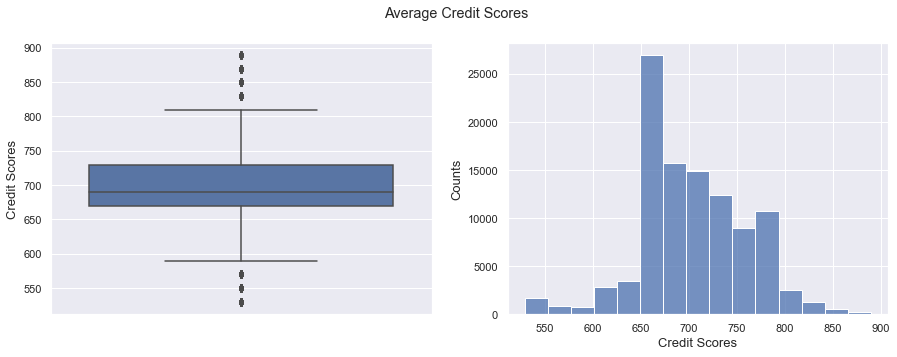

In [425]:
def explore_average_credit_score():
    '''
    Explore distribution of credit score.
    '''
    df = pd.read_csv(CLEANED_DATA)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=FIG_SIZE)
    fig.suptitle('Average Credit Scores')
    
    sns.boxplot(data=df, y='AvgCreditScore', ax=ax1)    
    ax1.set(xlabel='',
            ylabel='Credit Scores')
    
    sns.histplot(data=df, x='AvgCreditScore', ax=ax2, bins=15, alpha=0.75)
    ax2.set(xlabel='Credit Scores',
            ylabel='Counts')  
    
explore_average_credit_score()

## Bivariate Exploration
This section explore difference variables that affect rate and borrowing amount.

> ### Q: On average, which month people borrow the most money?
> * *I was surprise to see this trend*
> * *People started to borrow money from August and trailed off from January. I was thinking people need the most money in October to early November time frame to prepare for the holiday*

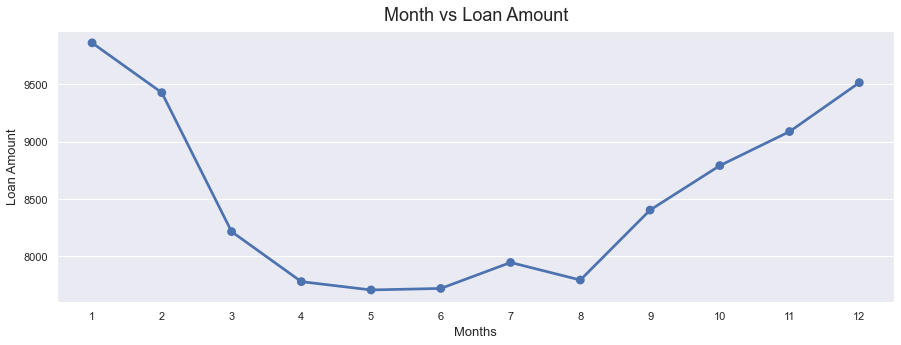

In [426]:
def explore_months_vs_loan_amount():
    '''
    Explore which month people borrow the most.
    '''
    df = pd.read_csv(CLEANED_DATA, parse_dates=[3])
    
    dates = df[['ListingCreationDate', 'LoanOriginalAmount']]
    dates.set_index('ListingCreationDate')
    dates = dates.groupby(by=[df.ListingCreationDate.dt.month]).mean()
    dates.columns = ['LoanAmount']
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    sns.pointplot(data=dates, y='LoanAmount', x=dates.index, ax=ax1, color=BASE_COLOR);

    ax1.set(title='Month vs Loan Amount',
            ylabel='Loan Amount',
            xlabel='Months')

explore_months_vs_loan_amount()

> ### Q: How much loan is carried by each state and which are the top five?
> * California is the number one state carries the most loans and is double the amount of the second most state, Texas.
> * Top Five States in descending order are: CA, TX, NY, FL, IL

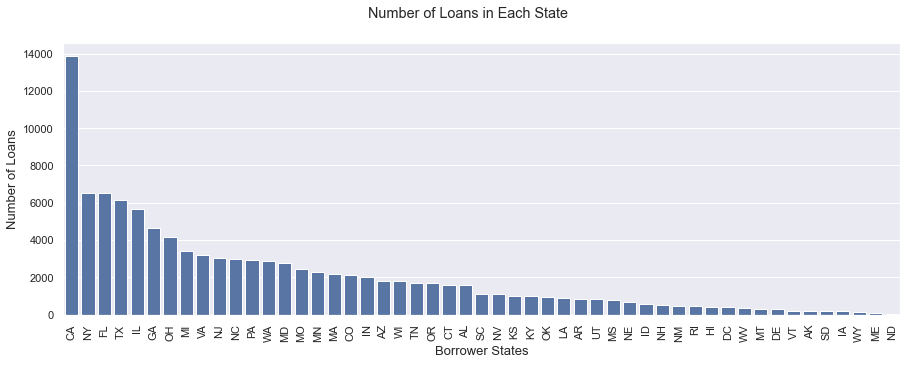

In [427]:
def explore_number_of_loans_vs_states():
    '''
    Explore loans across United States.
    '''
    df = pd.read_csv(CLEANED_DATA)
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    
    df_states = df.groupby(['BorrowerState']).ListingNumber.count()
    df_states = df_states.reset_index()
    df_states = df_states.sort_values(by=['ListingNumber'], ascending=False)
    
    fig.suptitle('Number of Loans in Each State')
    sns.barplot(data=df_states, x='BorrowerState', y='ListingNumber', ax=ax1, color=BASE_COLOR)
        
    ax1.set(xlabel='Borrower States',
            ylabel='Number of Loans')
    
    props = {'rotation': 90}
    plt.setp(ax1.get_xticklabels(), **props)
    
explore_number_of_loans_vs_states()

> ### Q: How is California compare to other states in total loan amount?
> Californians carried &#36;126,249,503

126249503


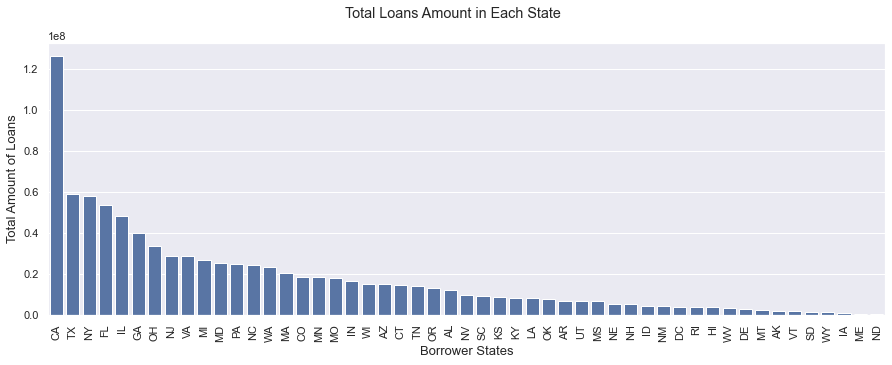

In [428]:
def explore_state_vs_total_loan_amount():
    '''
    Explore loan amount across United States.
    '''
    df = pd.read_csv(CLEANED_DATA)
    
    # Drop rows with NaN values
    nan_rows = df[df.BorrowerState.isnull()==True]
    df.drop(nan_rows.index, inplace=True)
    assert df.BorrowerState.isnull().sum() == 0
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    
    df_states = df.groupby(['BorrowerState']).LoanOriginalAmount.sum()
    df_states = df_states.reset_index()
    df_states = df_states.sort_values(by=['LoanOriginalAmount'], ascending=False)
    
    fig.suptitle('Total Loans Amount in Each State')
    sns.barplot(data=df_states, x='BorrowerState', y='LoanOriginalAmount', ax=ax1, color=BASE_COLOR)
        
    ax1.set(xlabel='Borrower States',
            ylabel='Total Amount of Loans')
    
    props = {'rotation': 90}
    plt.setp(ax1.get_xticklabels(), **props)
    
    print(df_states.LoanOriginalAmount.max())
    
explore_state_vs_total_loan_amount()

> ### Q: How credit score affect the borrowing amount?
> * *Overall, people with higher credit score got large amount of loans*
> * *People with credit score lower than 700 could only get maximum of loan of 25k*
> * *Majority of the loans is between 5k to 15k*

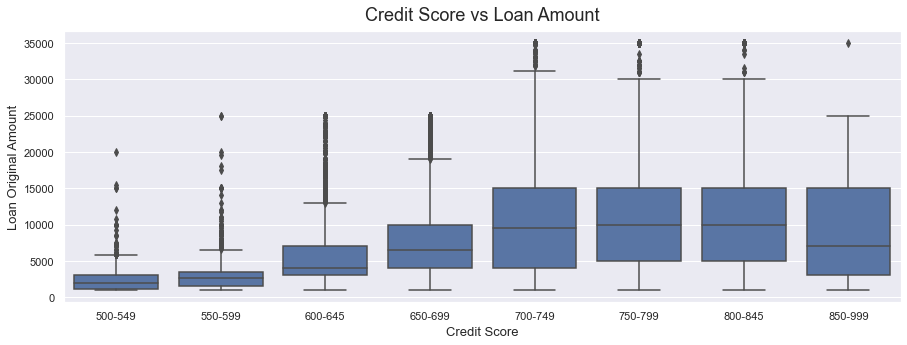

In [429]:
def explore_credit_score_vs_loan_amount():
    '''
    Explore how credit score relate to borrowing loan amount.
    '''
    df = pd.read_csv(CLEANED_DATA)
    data = df.sort_values('CreditRange')[['CreditRange', 'LoanOriginalAmount']]
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    sns.boxplot(data=data, x='CreditRange', y='LoanOriginalAmount', color=BASE_COLOR, ax=ax1)
    
    ax1.set(title='Credit Score vs Loan Amount',
            xlabel='Credit Score',
            ylabel='Loan Original Amount')
    
explore_credit_score_vs_loan_amount()

> ### Q: How  credit score affect the borrowing annual rate?
> * *Higher credit score has lower rate*
> * *Most people with credit score above 750 got loans with ~15% or lower*
> * *People with score lower than 600 got loan as high as ~35%*

count    103702.000000
mean          0.193475
std           0.075483
min           0.000100
25%           0.134000
50%           0.184000
75%           0.253700
max           0.360000
Name: BorrowerRate, dtype: float64


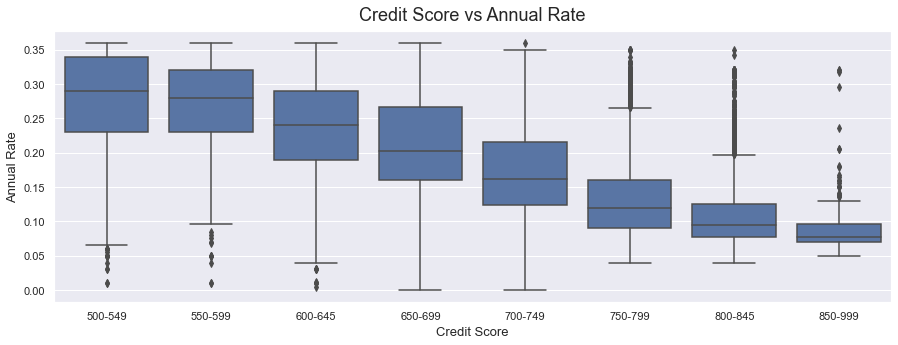

In [430]:
def explore_credit_score_vs_annual_rate():
    '''
    Explore how credit score affect annual rate.
    '''
    df = pd.read_csv(CLEANED_DATA)
    
    # Drop zero rate
    zeros = df.query('BorrowerRate==0')
    df = df.drop(zeros.index)
    
    data = df.sort_values('CreditRange')[['CreditRange', 'BorrowerRate', 'AvgCreditScore']]
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    sns.boxplot(data=data, x='CreditRange', y='BorrowerRate', color=BASE_COLOR, ax=ax1)
    
    ax1.set(title='Credit Score vs Annual Rate',
            xlabel='Credit Score',
            ylabel='Annual Rate')
        
    print(data.BorrowerRate.describe())
explore_credit_score_vs_annual_rate()

> ### Q: How credit score affects delinqencies?
> I am surprised to find delinquencies in the credit score 800+, and one case is as high as 6 occurances.

       CurrentDelinquencies  AmountDelinquent
count            176.000000        176.000000
mean               1.426136       5326.517045
std                0.904085      16262.977437
min                1.000000          0.000000
25%                1.000000          0.000000
50%                1.000000        198.500000
75%                1.000000       2610.250000
max                6.000000     149901.000000
      CreditRange  AmountDelinquent  CurrentDelinquencies  LoanOriginalAmount
51572     800-845             380.0                   6.0                8500


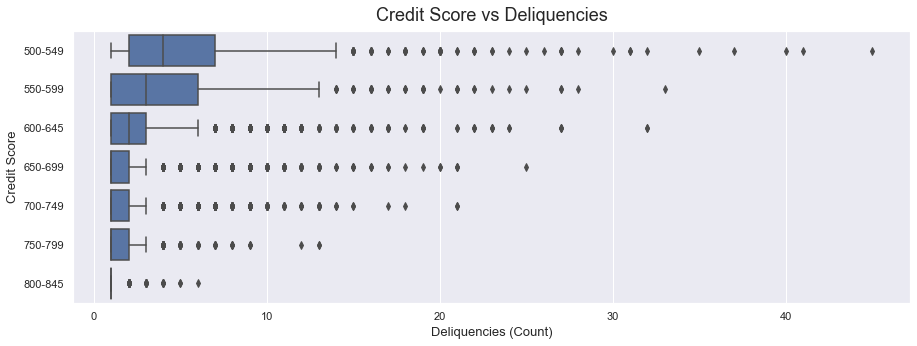

In [431]:
def explore_credit_score_vs_delinquencies():
    '''
    Explore how credit score affect deliquencies.
    '''
    df = pd.read_csv(CLEANED_DATA)
    # Drop outliners
    outliners = df.query('CurrentDelinquencies>45')
    df = df.drop(outliners.index)
    
    # Drop zero deliquencies
    zeros = df.query('CurrentDelinquencies==0')
    df = df.drop(zeros.index)
    data = df.sort_values('CreditRange')[['CreditRange', 'CurrentDelinquencies', 'AmountDelinquent']]

    # Credit score vs occurrencies
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    sns.boxplot(data=data, y='CreditRange', x='CurrentDelinquencies', color=BASE_COLOR, ax=ax1)
    
    ax1.set(title='Credit Score vs Deliquencies',
            xlabel='Deliquencies (Count)',
            ylabel='Credit Score')    
    
    print(data.query('CreditRange=="800-845"').describe())
    print(df.query('CreditRange=="800-845" & CurrentDelinquencies==6')[['CreditRange', 'AmountDelinquent', 'CurrentDelinquencies', 'LoanOriginalAmount']])
explore_credit_score_vs_delinquencies()

> ### Q: How credit score affect deliquent amount?
> From the above graph, there were a lot more deliquencies with lower credit scores; however, from this graph, it showed the banks were actually loosing more money on deliquencies with higher credit score.

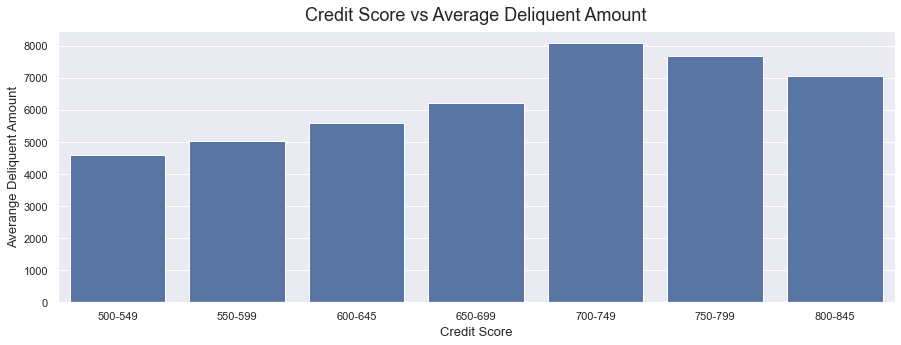

In [432]:
def explore_credit_score_vs_avg_delinquent_amount():
    '''
    Explore how credit score affect deliquencies.
    '''
    df = pd.read_csv(CLEANED_DATA)
    # Drop outliners
    outliners = df.query('AmountDelinquent>300000')
    df = df.drop(outliners.index)
    
    # Drop zero deliquencies
    zeros = df.query('AmountDelinquent==0')
    df = df.drop(zeros.index)
    
    # Average deliguent amount
    data = df.sort_values('CreditRange')[['CreditRange', 'AmountDelinquent']]
    data = data.groupby('CreditRange').AmountDelinquent.mean()
    data = data.reset_index()

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    sns.barplot(data=data, x='CreditRange', y='AmountDelinquent', color=BASE_COLOR, ax=ax1)

    ax1.set(title='Credit Score vs Average Deliquent Amount',
            xlabel='Credit Score',
            ylabel='Averange Deliquent Amount')    
    
explore_credit_score_vs_avg_delinquent_amount()

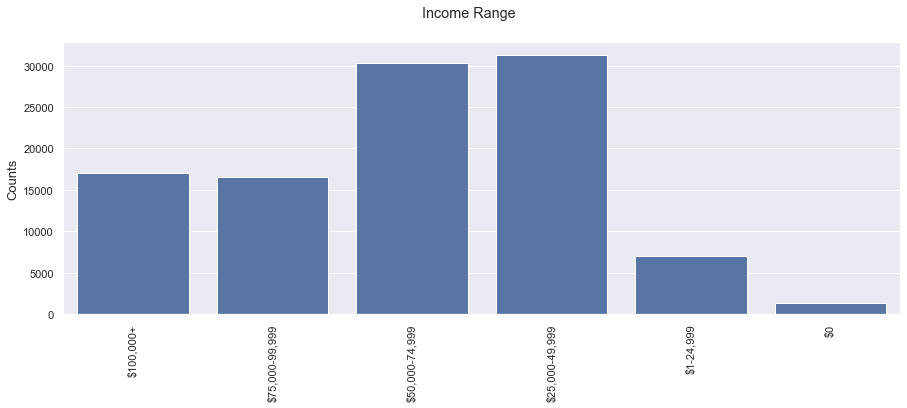

In [433]:
def explore_income_range():
    '''
    Explore income range variable.
    '''
    df = pd.read_csv(CLEANED_DATA)
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    fig.suptitle('Income Range')
    order = ['$100,000+', '$75,000-99,999', '$50,000-74,999', '$25,000-49,999', '$1-24,999', '$0']
    sns.countplot(data=df, x='IncomeRange', ax=ax1, color=BASE_COLOR, order=order)

    ax1.set(xlabel='',
            ylabel='Counts')
    
    props = {'rotation': 90}
    plt.setp(ax1.get_xticklabels(), **props)
    
explore_income_range()

> ### Q: How does income affect Loan amount?
> * *People with income below &#36;$50,000; got more smaller amount (~&#36;5000) of loans*
> * *People with income of &#36;100,000 or more got less loans but bigger amount of loans*

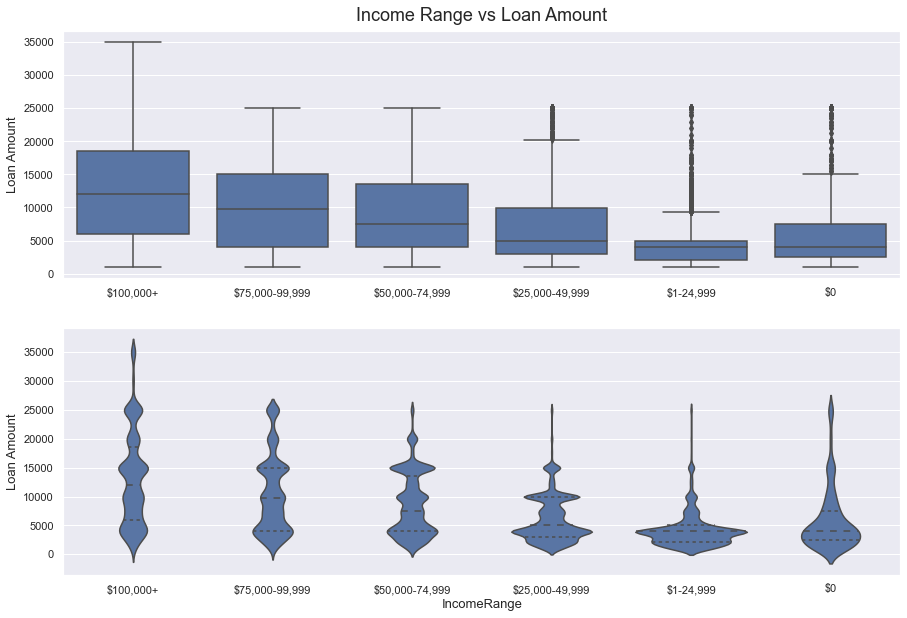

In [434]:
def explore_income_range_vs_loan_amount():
    '''
    Explore how income range affect loan amount.
    '''
    df = pd.read_csv(CLEANED_DATA)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=FIG_SIZE_TWO_ROWS)
        
    order = ['$100,000+', '$75,000-99,999', '$50,000-74,999', '$25,000-49,999', '$1-24,999', '$0']
    sns.boxplot(data=df, y='LoanOriginalAmount', x='IncomeRange', 
                   ax=ax1, color=BASE_COLOR, order=order);

    sns.violinplot(data=df, y='LoanOriginalAmount', x='IncomeRange', 
               ax=ax2, color=BASE_COLOR, order=order, inner='quartile');

    ax1.set(title='Income Range vs Loan Amount',
            ylabel='Loan Amount',
            xlabel='')
    
    ax2.set(ylabel='Loan Amount')
    
explore_income_range_vs_loan_amount()

> ### Q: How is terms relate to loan amount?
> * *Most of the loan ~&#36;7500 and below were either 12 months or 36 months term*
> * *Most of the loan higher than ~&#36;7500 were 60 months term*

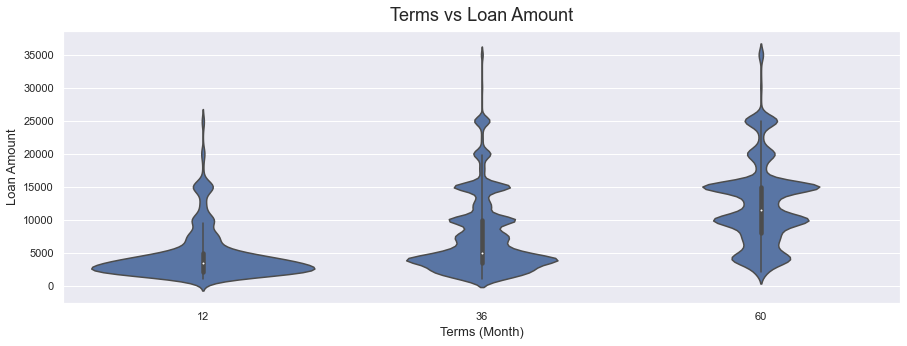

In [435]:
def explore_terms_vs_loan_amount():
    '''
    Explore how loan terms affect loan amount.
    '''
    df = pd.read_csv(CLEANED_DATA)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    sns.violinplot(data=df, y='LoanOriginalAmount', x='Term', ax=ax1, color=BASE_COLOR);

    ax1.set(title='Terms vs Loan Amount',
            ylabel='Loan Amount',
            xlabel='Terms (Month)')
    
explore_terms_vs_loan_amount()

## Multivariate Exploration

> ### Explore Loan Amount, Interest Rate and Credit Range
> * *Take a deeper look into the relationship with loan amount and interest rate*
> * *Only use sample size of 5000 so it doesn't look like overplotting

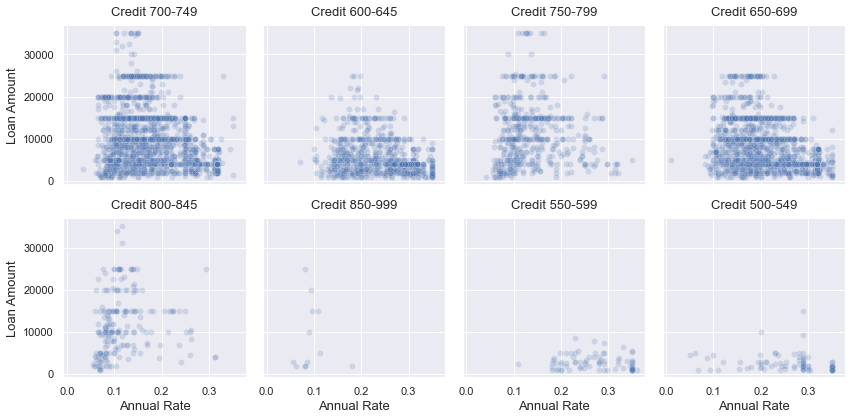

In [436]:
def explore_loan_amount_interest_rate_with_credit_range():
    df = pd.read_csv(CLEANED_DATA)
    data = df.sort_values('CreditRange')[['BorrowerRate', 'LoanOriginalAmount', 'CreditRange']]
            
    g = sns.FacetGrid(data=data.sample(5000), col='CreditRange', col_wrap=4)
    g.map(sns.scatterplot, 'BorrowerRate', 'LoanOriginalAmount', alpha=0.2)
    
    g.set_axis_labels('Annual Rate', 'Loan Amount')
    g.set_titles(col_template='Credit {col_name}')
#     g.set_titles(col_template="Credit {col_name}", row_template="{row_name}")
        
explore_loan_amount_interest_rate_with_credit_range()

## Conclusions
When exploring each variable individually, I found many data quality issues that need to be futher addressed before moving on to bivariate exploration. With the bivariate exploration, looking into relationships provided me most of the insights. I am surprised to find these insights during the bivariate exploration.
* The trend that people started to borrow money as early as August and trailed off after January. My impression was people need the most money in October to early November time frame to prepare for the holiday and before Summer start.
* California is the number one state that carried the most loans and is double the number of loans of the second most state, Texas.
* You need credit score above 730 to get loans above &#36;25,000 and you most likely can not get any loan if your credit score is less than 530.
* People with loan higher then &#36;25,000 actually paid less in interest rate than lower amount of loans.
* There were a few deliquencies with credit score of 850.